✅ All CMAPSS files found locally in 'data/'.
Dropping sensors: ['s1', 's5', 's6', 's10', 's16', 's18', 's19']
Total features used: 59
Saved rul scaler to rul_scaler.joblib
Saved feature scaler to feat_scaler.joblib
Shapes → (12641, 50, 59) (12641, 1) (3090, 50, 59) (3090, 1) (8255, 50, 59) (8255, 1)
Epoch 1/40 | Train MSE=0.075073 | Val RMSE(scaled)=0.134897
Epoch 2/40 | Train MSE=0.019990 | Val RMSE(scaled)=0.107141
Epoch 3/40 | Train MSE=0.015283 | Val RMSE(scaled)=0.082773
Epoch 4/40 | Train MSE=0.013691 | Val RMSE(scaled)=0.087327
Epoch 5/40 | Train MSE=0.013523 | Val RMSE(scaled)=0.087007
Epoch 6/40 | Train MSE=0.013014 | Val RMSE(scaled)=0.085586
Epoch 7/40 | Train MSE=0.012731 | Val RMSE(scaled)=0.091750
Epoch 8/40 | Train MSE=0.011875 | Val RMSE(scaled)=0.086584
Epoch 9/40 | Train MSE=0.011696 | Val RMSE(scaled)=0.087525
Early stopping triggered.
Saved model and training artifacts.

Final Test RMSE (cycles): 13.066
Saved test predictions to test_preds_final.csv


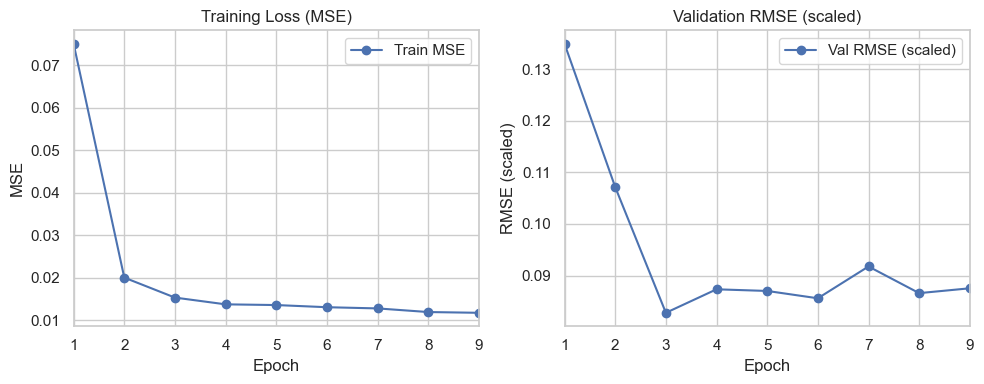

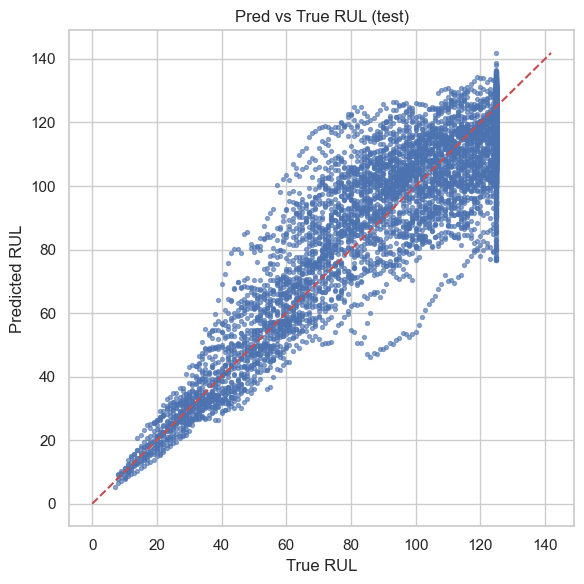

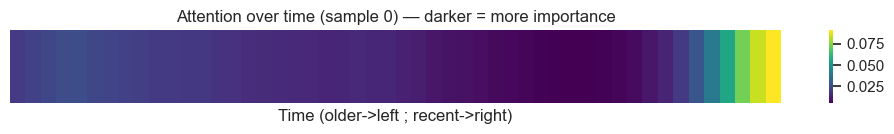

All done. Artifacts saved:
 - Model: best_model_final.pth
 - Feature scaler: feat_scaler.joblib
 - RUL scaler: rul_scaler.joblib
 - Predictions CSV: test_preds_final.csv
 - Numpy artifacts: train_losses.npy, val_rmses.npy, test_weights.npy


In [2]:
"""
Predict Remaining Useful Life (RUL) on NASA CMAPSS FD001 using a Bi-directional LSTM with Attention.

- RUL cap = 125: caps very large RUL values so the model doesn't focus only on rare huge targets.
- ReduceLROnPlateau: automatically reduces LR when validation metric stops improving;
  useful to fine-tune the model after initial learning.
- Gradient clipping: prevents exploding gradients by limiting parameter update magnitudes.
- Attention: provides per-timestep importance — good for explainability in sequences.
"""

# ---------------------------
# Imports
# ---------------------------
import os
import copy
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import joblib               # for saving scalers / objects

# ML / Torch / Sklearn
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

sns.set(style="whitegrid")

# ---------------------------
# Config / Constants
# ---------------------------
DATA_DIR = Path("data")
FD = "FD001"             # currently using FD001 (single operating condition)
SEQ_LEN = 50
RUL_CAP = 125
BATCH = 64
LR = 5e-4
EPOCHS = 40
PATIENCE = 6             # early stopping patience
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Filenames for saved artifacts
MODEL_PATH = "best_model_final.pth"
FEAT_SCALER_PATH = "feat_scaler.joblib"
RUL_SCALER_PATH = "rul_scaler.joblib"
TRAIN_LOSSES_PATH = "train_losses.npy"
VAL_RMSES_PATH = "val_rmses.npy"
TEST_WEIGHTS_PATH = "test_weights.npy"
TEST_PREDS_CSV = "test_preds_final.csv"

# ---------------------------
# Utility functions
# ---------------------------
def download_if_missing():
    """
    Optional helper: prints notice if dataset files are missing.
    (Kaggle auto-downloads are often blocked; we're explicit.)
    """
    expected = [f"{p}_{FD}.txt" for p in ["train","test","RUL"]]
    missing = [f for f in expected if not (DATA_DIR / f).exists()]
    if not missing:
        print("✅ All CMAPSS files found locally in 'data/'.")
        return
    print("⚠️ Missing CMAPSS files. Please download FD001 files to 'data/'.")
    return

# ---------------------------
# 1. Load dataset helper
# ---------------------------
def load_fd(fd=FD):
    """
    Returns: train_df, test_df, rul_df for the given FD subset.
    Columns: ['unit','time','op_setting_1','op_setting_2','op_setting_3','s1',...,'s21']
    """
    cols = (["unit", "time"] +
            [f"op_setting_{i}" for i in range(1,4)] +
            [f"s{i}" for i in range(1,22)])
    train = pd.read_csv(DATA_DIR / f"train_{fd}.txt", sep=r"\s+", header=None, names=cols)
    test  = pd.read_csv(DATA_DIR / f"test_{fd}.txt",  sep=r"\s+", header=None, names=cols)
    rul   = pd.read_csv(DATA_DIR / f"RUL_{fd}.txt",   sep=r"\s+", header=None, names=["RUL"])
    return train, test, rul

# ---------------------------
# 2. Compute RUL targets
# ---------------------------
def compute_rul(train, test, rul):
    """
    For training set: RUL = max_cycle_for_unit - current_time
    For test set: RUL = provided_RUL + (last_cycle - current_time)
    """
    # Train RUL
    train_max = train.groupby("unit")["time"].max().reset_index().rename(columns={"time": "max_cycle"})
    train = train.merge(train_max, on="unit")
    train["RUL"] = train["max_cycle"] - train["time"]
    train.drop(columns="max_cycle", inplace=True)

    # Test RUL
    last_cycle = test.groupby("unit")["time"].max().reset_index().rename(columns={"time": "last_cycle"})
    test = test.merge(last_cycle, on="unit")
    unit_ids = sorted(test["unit"].unique())
    test["provided_RUL"] = test["unit"].map({uid: float(rul.iloc[i,0]) for i, uid in enumerate(unit_ids)})
    test["RUL"] = test["provided_RUL"] + (test["last_cycle"] - test["time"])

    return train, test

# ---------------------------
# 3. Feature engineering
# ---------------------------
def add_rolling(df, sensors, windows=(3,6)):
    """
    Add rolling mean (size windows) and first-difference (delta) per sensor,
    computed separately for each engine unit.

    New columns:
      - <sensor>_rmean3, <sensor>_rmean6
      - <sensor>_d (first diff)
    """
    df = df.copy()
    for w in windows:
        roll = df.groupby("unit")[sensors].rolling(w, min_periods=1).mean().reset_index(level=0, drop=True)
        roll.columns = [f"{c}_rmean{w}" for c in sensors]
        df = pd.concat([df, roll], axis=1)
    diff = df.groupby("unit")[sensors].diff().fillna(0)
    diff.columns = [f"{c}_d" for c in sensors]
    df = pd.concat([df, diff], axis=1)
    return df

# ---------------------------
# 4. Sequence creation
# ---------------------------
def create_sequences(df, seq_len=SEQ_LEN, features=None, target="RUL_scaled"):
    """
    Sliding-window sequences per engine unit.
    Returns X: (n_samples, seq_len, n_features), y: (n_samples, 1)
    """
    if features is None:
        raise ValueError("Provide feature column list")

    X, y = [], []
    for _, g in df.groupby("unit"):
        arr, targ = g[features].values, g[target].values
        for i in range(len(g) - seq_len + 1):
            X.append(arr[i:i+seq_len])
            y.append(targ[i+seq_len-1])
    return np.array(X, np.float32), np.array(y, np.float32).reshape(-1, 1)

# ---------------------------
# 5. Attention + BiLSTM Model
# ---------------------------
class Attention(nn.Module):
    """
    MLP-based timestep attention.
    Input: h -> (batch, seq_len, hidden_dim)
    Output: context_vector (batch, hidden_dim), weights (batch, seq_len, 1)
    """
    def __init__(self, hidden):
        super().__init__()
        self.score = nn.Sequential(
            nn.Linear(hidden, hidden // 2),
            nn.Tanh(),
            nn.Linear(hidden // 2, 1)
        )

    def forward(self, h):
        # h: (batch, seq_len, hidden)
        scores = self.score(h)                       # (batch, seq_len, 1)
        weights = torch.softmax(scores, dim=1)       # normalize across time
        context = (h * weights).sum(dim=1)           # (batch, hidden)
        return context, weights

class BiLSTM_Attn(nn.Module):
    """
    Bi-directional LSTM -> Attention -> MLP head (ReLU + Dropout)
    """
    def __init__(self, input_dim, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=2,
                            batch_first=True, dropout=0.2, bidirectional=True)
        self.attn = Attention(hidden * 2)
        self.fc = nn.Sequential(
            nn.Linear(hidden * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)            # (batch, seq_len, hidden*2)
        ctx, weights = self.attn(out)    # ctx: (batch, hidden*2)
        return self.fc(ctx), weights

# ---------------------------
# 6. Training & evaluation helpers
# ---------------------------
def rmse(a, b):
    return math.sqrt(np.mean((a - b) ** 2))

def fit_and_eval(X_train, y_train, X_val, y_val, X_test, y_test,
                 features, save_path=MODEL_PATH):
    """
    Train model and evaluate on validation/test.
    Returns dict with model, storages and raw scaled preds/weights.
    - Saves: model state, train_losses/val_rmses, and test_weights as numpy files.
    """
    # DataLoaders (torch tensors)
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
                              batch_size=BATCH, shuffle=True)
    val_loader   = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)),
                              batch_size=BATCH)
    test_loader  = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)),
                              batch_size=BATCH)

    model = BiLSTM_Attn(input_dim=X_train.shape[2]).to(DEVICE)
    criterion = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=LR)

    # ReduceLROnPlateau: when val metric plateaus, shrink LR by factor. Good for fine-tuning.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)

    best_rmse, stale = np.inf, 0
    best_state = None
    train_losses, val_rmses = [], []

    for e in range(EPOCHS):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            p, _ = model(xb)
            loss = criterion(p, yb)
            loss.backward()
            # Gradient clipping: prevents exploding gradients; clip norm to 1
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            opt.step()
            run_loss += loss.item() * xb.size(0)
        tr_loss = run_loss / len(train_loader.dataset)
        train_losses.append(tr_loss)

        # validation
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                p, _ = model(xb)
                preds.append(p.cpu().numpy()); trues.append(yb.cpu().numpy())
        preds = np.concatenate(preds).ravel(); trues = np.concatenate(trues).ravel()
        v_rmse = rmse(trues, preds)   # RMSE on scaled targets
        val_rmses.append(v_rmse)
        scheduler.step(v_rmse)        # feed metric to LR scheduler

        print(f"Epoch {e+1}/{EPOCHS} | Train MSE={tr_loss:.6f} | Val RMSE(scaled)={v_rmse:.6f}")

        # Early stopping logic (stale count increments if no improvement)
        if v_rmse < best_rmse - 1e-6:
            best_rmse, stale = v_rmse, 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            stale += 1
            if stale >= PATIENCE:
                print("Early stopping triggered.")
                break

    # load best state if found
    if best_state is not None:
        model.load_state_dict(best_state)
    else:
        print("No best state found; model left at final epoch weights.")

    # test evaluation (collect predictions and attention weights)
    model.eval()
    preds, trues, weights = [], [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            p, w = model(xb)
            preds.append(p.cpu().numpy()); trues.append(yb.cpu().numpy()); weights.append(w.cpu().numpy())

    preds = np.concatenate(preds).ravel()
    trues = np.concatenate(trues).ravel()
    weights = np.concatenate(weights, axis=0)  # (n_samples, seq_len, 1)

    # save artifacts
    torch.save(model.state_dict(), save_path)
    np.save(TRAIN_LOSSES_PATH, np.array(train_losses))
    np.save(VAL_RMSES_PATH, np.array(val_rmses))
    np.save(TEST_WEIGHTS_PATH, weights)
    print("Saved model and training artifacts.")

    return {
        "model": model,
        "train_losses": train_losses,
        "val_rmses": val_rmses,
        "test_preds_scaled": preds,
        "test_trues_scaled": trues,
        "test_weights": weights,
        "best_val_rmse_scaled": best_rmse,
        "save_path": save_path
    }

# ---------------------------
# 7. Visualization helpers (compact)
# ---------------------------
def plot_learning_curves(train_losses, val_rmses, savepath=None):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label="Train MSE")
    plt.title("Training Loss (MSE)")
    plt.xlabel("Epoch"); plt.ylabel("MSE")
    plt.xlim(1, len(train_losses))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(val_rmses)+1), val_rmses, marker='o', label="Val RMSE (scaled)")
    plt.title("Validation RMSE (scaled)")
    plt.xlabel("Epoch"); plt.ylabel("RMSE (scaled)")
    plt.xlim(1, len(val_rmses))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()

def plot_pred_vs_true(true_rul, pred_rul, savepath=None):
    plt.figure(figsize=(6,6))
    plt.scatter(true_rul, pred_rul, s=8, alpha=0.6)
    mx = max(true_rul.max(), pred_rul.max())
    plt.plot([0, mx], [0, mx], 'r--')
    plt.xlabel("True RUL"); plt.ylabel("Predicted RUL")
    plt.title("Pred vs True RUL (test)")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()

def plot_attention_heatmap(weights, sample_idx=0, savepath=None):
    """
    weights: array shape (n_samples, seq_len, 1)
    sample_idx: which sample to visualize
    """
    attn = weights[sample_idx].squeeze()  # (seq_len,)
    plt.figure(figsize=(10,1.5))
    sns.heatmap(attn[np.newaxis, :], cmap="viridis", cbar=True, xticklabels=False, yticklabels=False)
    plt.title(f"Attention over time (sample {sample_idx}) — darker = more importance")
    plt.xlabel("Time (older->left ; recent->right)")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()

# ---------------------------
# 8. main routine
# ---------------------------
if __name__ == "__main__":
    download_if_missing()
    train, test, rul = load_fd(FD)
    train, test = compute_rul(train, test, rul)

    # sensors & ops
    ALL_SENSORS = [f"s{i}" for i in range(1,22)]
    OPS = [f"op_setting_{i}" for i in range(1,4)]
    FEATURES = OPS + ALL_SENSORS

    # drop near-zero variance sensors (if any)
    low_var = train[ALL_SENSORS].var()
    drop_sensors = low_var[low_var < 1e-5].index.tolist()
    if drop_sensors:
        print("Dropping sensors:", drop_sensors)
        ALL_SENSORS = [s for s in ALL_SENSORS if s not in drop_sensors]
    FEATURES = OPS + ALL_SENSORS

    # add rolling + delta features
    train_fe = add_rolling(train, ALL_SENSORS)
    test_fe  = add_rolling(test,  ALL_SENSORS)

    # extended feature list
    ROLL_COLS = [c for c in train_fe.columns if ("_rmean" in c) or c.endswith("_d")]
    FEATURES_EXT = FEATURES + ROLL_COLS
    print("Total features used:", len(FEATURES_EXT))

    # target scaling (cap + MinMax)
    train_fe["RUL_capped"] = train_fe["RUL"].clip(upper=RUL_CAP)
    rul_scaler = MinMaxScaler()
    train_fe["RUL_scaled"] = rul_scaler.fit_transform(train_fe[["RUL_capped"]])

    # save rul scaler for inference
    joblib.dump(rul_scaler, RUL_SCALER_PATH)
    print("Saved rul scaler to", RUL_SCALER_PATH)

    # split units into train/val by unit id
    np.random.seed(42)
    units = train_fe["unit"].unique()
    np.random.shuffle(units)
    n_val = int(len(units) * 0.2)
    val_units = units[:n_val]
    train_df = train_fe[~train_fe["unit"].isin(val_units)].reset_index(drop=True)
    val_df   = train_fe[train_fe["unit"].isin(val_units)].reset_index(drop=True)

    # prepare test scaling
    test_fe["RUL_capped"] = test_fe["RUL"].clip(upper=RUL_CAP)
    test_fe["RUL_scaled"] = rul_scaler.transform(test_fe[["RUL_capped"]])

    # feature scaling (fit on train_df only)
    feat_scaler = MinMaxScaler().fit(train_df[FEATURES_EXT])
    # avoid pandas dtype warning by explicit float32 casts
    for df in [train_df, val_df, test_fe]:
        df[FEATURES_EXT] = df[FEATURES_EXT].astype(np.float32)
        df.loc[:, FEATURES_EXT] = feat_scaler.transform(df[FEATURES_EXT]).astype(np.float32)

    # save feat scaler for inference
    joblib.dump(feat_scaler, FEAT_SCALER_PATH)
    print("Saved feature scaler to", FEAT_SCALER_PATH)

    # create sequences
    X_train, y_train = create_sequences(train_df, seq_len=SEQ_LEN, features=FEATURES_EXT, target="RUL_scaled")
    X_val, y_val     = create_sequences(val_df,   seq_len=SEQ_LEN, features=FEATURES_EXT, target="RUL_scaled")
    X_test, y_test   = create_sequences(test_fe,  seq_len=SEQ_LEN, features=FEATURES_EXT, target="RUL_scaled")
    print("Shapes →", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

    # train + eval
    out = fit_and_eval(X_train, y_train, X_val, y_val, X_test, y_test, FEATURES_EXT,
                       save_path=MODEL_PATH)

    # invert scaled preds -> cycles (human-readable)
    preds_inv = rul_scaler.inverse_transform(out["test_preds_scaled"].reshape(-1, 1)).ravel()
    trues_inv = rul_scaler.inverse_transform(out["test_trues_scaled"].reshape(-1, 1)).ravel()

    # compute final RMSE in cycles
    test_rmse = rmse(trues_inv, preds_inv)
    print(f"\nFinal Test RMSE (cycles): {test_rmse:.3f}")

    # save final predictions CSV (readable)
    pd.DataFrame({"true_RUL": trues_inv, "pred_RUL": preds_inv}).to_csv(TEST_PREDS_CSV, index=False)
    print("Saved test predictions to", TEST_PREDS_CSV)

    # save numpy artifacts (already saved inside fit_and_eval for training arrays)
    # save preds/true as numpy also for reproducibility
    np.save("test_preds_scaled.npy", out["test_preds_scaled"])
    np.save("test_trues_scaled.npy", out["test_trues_scaled"])

    # example plots (optional - saves nothing by default)
    plot_learning_curves(out["train_losses"], out["val_rmses"], savepath="learning_curves.png")
    plot_pred_vs_true(pd.Series(trues_inv), pd.Series(preds_inv), savepath="pred_vs_true.png")
    plot_attention_heatmap(out["test_weights"], sample_idx=0, savepath="attention_sample0.png")

    print("All done. Artifacts saved:")
    print(" - Model:", MODEL_PATH)
    print(" - Feature scaler:", FEAT_SCALER_PATH)
    print(" - RUL scaler:", RUL_SCALER_PATH)
    print(" - Predictions CSV:", TEST_PREDS_CSV)
    print(" - Numpy artifacts: train_losses.npy, val_rmses.npy, test_weights.npy")
